--- Bắt đầu chương trình ---


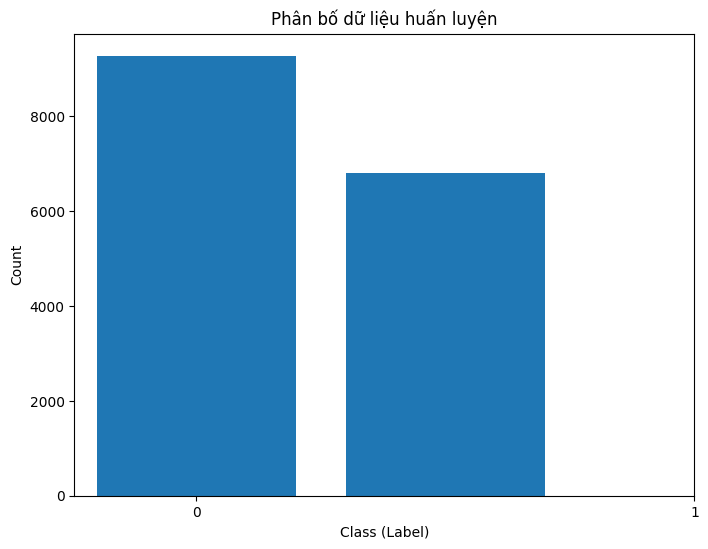

Đã lưu biểu đồ phân bố dữ liệu vào data_distribution_tfidf.png

--- Tối ưu tham số (GridSearchCV) ---
OptimizeParams - Best Parameters: {'C': 1, 'kernel': 'linear'}, Best F1 Score (CV): 0.8881

Tham số tốt nhất từ GridSearchCV: {'C': 1, 'kernel': 'linear'}, F1 (CV): 0.8881
Sử dụng C=1, kernel='linear' để huấn luyện model cuối cùng.

--- Huấn luyện và Đánh giá Model ---

Huấn luyện model đánh giá (C=1, kernel=linear) trên 80% dữ liệu...
Độ chính xác trên tập kiểm tra (split 80/20): 0.9086

Ma trận nhầm lẫn trên tập kiểm tra (split 80/20):
[[1657  199]
 [  95 1267]]


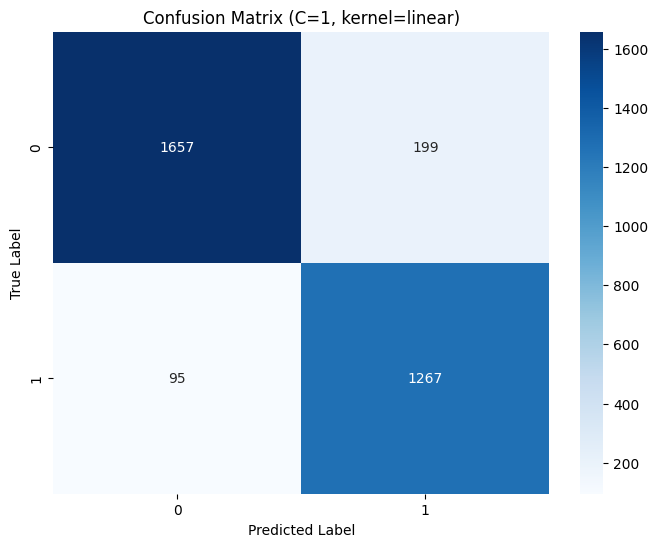


Huấn luyện model cuối cùng (C=1, kernel=linear) trên toàn bộ dữ liệu (100%)...
Đã lưu model cuối cùng (huấn luyện trên toàn bộ dữ liệu) vào /content/best_model.pkl

--- Phân loại câu ---
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): bộ đồ này đẹp quá
Dự đoán: Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): mê quá
Dự đoán: Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): đẹp nhưng khá đắt
Dự đoán: Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): đắt và xấu quá
Dự đoán: Bình luận tiêu cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): khá phù hợp với tôi 
Dự đoán: Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): exit

--- Chương trình kết thúc ---


In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split # Thêm train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score # Thêm confusion_matrix, accuracy_score
import seaborn as sns # Thêm seaborn

PATH_DATA = "/content/train.crash" # Đặt tên biến rõ ràng hơn

# Load và xử lý dữ liệu
class DataSource:
    def _load_raw_data(self, filename, is_train=True):
        lines_buffer = []
        all_samples_lines = []
        regex = 'train_' if is_train else 'test_'

        try:
            with open(filename, "r", encoding="utf-8") as file:
                for line in file:
                    line_stripped = line.strip()
                    if regex in line_stripped and line_stripped.startswith(regex):
                        if lines_buffer:
                            all_samples_lines.append(list(lines_buffer))
                            lines_buffer.clear()
                        lines_buffer.append(line_stripped)
                    elif line_stripped:
                        lines_buffer.append(line_stripped)

            if lines_buffer:
                all_samples_lines.append(list(lines_buffer))

        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file {filename}")
            return []
        return all_samples_lines

    def _create_row(self, sample_lines, is_train=True):
        if not sample_lines:
            return None

        d = {'id': sample_lines[0]}

        if is_train:
            if len(sample_lines) < 2: # Cần ID và ít nhất 1 dòng nữa (review/nhãn)
                # print(f"Cảnh báo: Sample huấn luyện {d['id']} không đủ dòng.")
                return None # Bỏ qua sample không hoàn chỉnh

            label_candidate = sample_lines[-1]
            if label_candidate.isdigit():
                d['label'] = int(label_candidate)
                review_lines = sample_lines[1:-1]
            else:
                # print(f"Cảnh báo: Sample huấn luyện {d['id']} thiếu nhãn hoặc nhãn không hợp lệ ('{label_candidate}').")
                return None # Bỏ qua sample thiếu nhãn hợp lệ
        else: # Dữ liệu test không có nhãn
            if len(sample_lines) < 1: # Cần ít nhất ID
                return None
            review_lines = sample_lines[1:]

        d['review'] = " ".join(clause.strip() for clause in review_lines if clause.strip()) # Nối và bỏ dòng trống
        # if not d['review'] and is_train :
            # print(f"Cảnh báo: Review rỗng cho ID {d['id']} với nhãn {d.get('label','N/A')}.")
            # return None # Bỏ qua sample có review rỗng
        return d

    def load_data(self, filename, is_train=True):
        raw_samples_lines = self._load_raw_data(filename, is_train)
        processed_rows = []
        if not raw_samples_lines:
            # print(f"Không có sample thô nào được tải từ {filename}.")
            return []

        for lines_for_sample in raw_samples_lines:
            row = self._create_row(lines_for_sample, is_train)
            if row:
                processed_rows.append(row)

        if not processed_rows:
            print(f"Không có dữ liệu hợp lệ nào được xử lý từ {filename}. Vui lòng kiểm tra định dạng file.")
        return processed_rows


# Trực quan hóa dữ liệu
def visualize_data(path):
    ds = DataSource()
    data_list = ds.load_data(path, is_train=True) # is_train=True để load nhãn
    if not data_list:
        print("Không có dữ liệu để trực quan hóa.")
        return

    train_data = pd.DataFrame(data_list)
    if train_data.empty or 'label' not in train_data.columns:
        print("Dữ liệu rỗng hoặc không có cột 'label' sau khi tải.")
        return

    if train_data['label'].isnull().all():
        print("Cột 'label' chứa toàn giá trị null.")
        return

    # Loại bỏ các hàng có nhãn NaN nếu có trước khi vẽ
    valid_labels = train_data.dropna(subset=['label'])['label']
    if valid_labels.empty:
        print("Không có nhãn hợp lệ để trực quan hóa sau khi loại bỏ NaN.")
        return

    plt.figure(figsize=(8,6))
    # Đảm bảo chỉ vẽ hist cho các nhãn số
    numeric_labels = pd.to_numeric(valid_labels, errors='coerce').dropna()
    if numeric_labels.empty:
        print("Không có nhãn dạng số hợp lệ để vẽ biểu đồ tần suất.")
        return

    plt.hist(numeric_labels.to_numpy(), bins=len(numeric_labels.unique()), rwidth=0.8, align='left')
    plt.xlabel("Class (Label)")
    plt.ylabel("Count")
    plt.title("Phân bố dữ liệu huấn luyện")
    plt.xticks(sorted(numeric_labels.unique().astype(int)))
    plt.savefig('data_distribution_tfidf.png')
    plt.show()
    print("Đã lưu biểu đồ phân bố dữ liệu vào data_distribution_tfidf.png")


# Tiền xử lý văn bản
class Util:
    dict_replace = {
        "ship": "vận chuyển","shop": "cửa hàng","m": "mình","mik":"mình","ko":"không","k":"không","kh":"không","khong":"không","kg":"không","khg":"không","tl":"trả lời",
"rep":"trả lời","r":"rồi","fb":"facebook","face":"faceook","thanks":"cảm ơn","thank":"cảm ơn","tks":"cảm ơn","tk":"cảm ơn","ok":"tốt","oki":"tốt","okie":"tốt","sp":"sản phẩm",
"dc":"được","vs":"với","đt":"điện thoại","thjk":"thích","thik":"thích","qá":"quá","trể":"trễ","bgjo":"bao giờ","h":"giờ","qa":"quá","dep":"đẹp","xau":"xấu","ib":"nhắn tin",
"cute":"dễ thương","sz":"size","good":"tốt","god":"tốt","bt":"bình thường"
    }

    def remove_redundant(self, text):
        if not isinstance(text, str): return ""
        return re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    def normalize(self, text):
        if not isinstance(text, str): return ""
        text = text.lower()
        words = text.split()
        words = [self.dict_replace.get(w, w) for w in words]
        return " ".join(words)

    def process_text(self, text):
        text = self.remove_redundant(text)
        return self.normalize(text)


# Mô hình TF-IDF
class DictTfidf:
    def __init__(self, path_to_data): # Đổi tên path để rõ ràng
        self.path_to_data = path_to_data
        self.util = Util()
        self.ds = DataSource()

    def create_vectorizer(self):
        # Chỉ đọc dữ liệu một lần để tạo vectorizer
        data_list = self.ds.load_data(self.path_to_data, is_train=True)
        if not data_list:
            print("Không có dữ liệu để tạo vectorizer.")
            return None

        reviews = [item['review'] for item in data_list if item.get('review')]
        if not reviews:
            print("Không có review nào để tạo vectorizer.")
            return None

        processed_data = [self.util.process_text(text) for text in reviews]

        vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
        vectorizer.fit(processed_data)
        return vectorizer

# Tối ưu tham số
class OptimizeParams:
    def __init__(self, path_to_data, vectorizer_instance=None): # Có thể nhận vectorizer đã tạo
        self.path_to_data = path_to_data
        self.util = Util()
        self.ds = DataSource()
        self.vectorizer = vectorizer_instance

    def optimize(self):
        # Tạo vectorizer nếu chưa có
        if not self.vectorizer:
            print("OptimizeParams: Tạo vectorizer mới...")
            tfidf_creator = DictTfidf(self.path_to_data)
            self.vectorizer = tfidf_creator.create_vectorizer()
            if not self.vectorizer:
                print("OptimizeParams: Không thể tạo vectorizer. Dừng tối ưu.")
                return None, None # Trả về tuple để unpack

        # Load và xử lý dữ liệu
        train_data_list = self.ds.load_data(self.path_to_data, is_train=True)
        if not train_data_list:
            print("OptimizeParams: Không có dữ liệu huấn luyện. Dừng tối ưu.")
            return None, None

        df_train_data = pd.DataFrame(train_data_list)
        if df_train_data.empty or 'review' not in df_train_data.columns or 'label' not in df_train_data.columns:
            print("OptimizeParams: Dữ liệu không hợp lệ. Dừng tối ưu.")
            return None, None

        # Lọc review và label hợp lệ
        df_train_data = df_train_data.dropna(subset=['review', 'label'])
        if df_train_data.empty:
            print("OptimizeParams: Không có dữ liệu hợp lệ sau khi lọc NaN. Dừng tối ưu.")
            return None, None

        x_texts = df_train_data.review.tolist()
        y_labels = df_train_data.label.astype(int) # Đảm bảo y là int

        if not x_texts:
             print("OptimizeParams: Không có văn bản để vector hóa. Dừng tối ưu.")
             return None, None

        processed_texts = [self.util.process_text(t) for t in x_texts]
        x_train_tfidf = self.vectorizer.transform(processed_texts)

        if x_train_tfidf.shape[0] == 0:
            print("OptimizeParams: Dữ liệu TF-IDF rỗng. Dừng tối ưu.")
            return None, None

        param_grid = {'C': [0.01, 0.1, 1, 5, 10], 'kernel': ['linear']} # Giảm số lượng C để nhanh hơn
        # Sử dụng scoring='f1_weighted' nếu dữ liệu mất cân bằng, hoặc 'f1' nếu chỉ có 2 lớp chính
        # và bạn quan tâm đến lớp dương (thường là 1)
        # Mặc định f1 cho binary là f1 của positive class.
        # Nếu đa lớp, cần f1_macro, f1_weighted, etc.
        # Giả sử nhãn là 0 và 1.
        scoring_metric = 'f1' if len(y_labels.unique()) <= 2 else 'f1_weighted'

        clf = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring=scoring_metric, n_jobs=-1) # cv=3 cho nhanh
        try:
            clf.fit(x_train_tfidf, y_labels)
            print(f"OptimizeParams - Best Parameters: {clf.best_params_}, Best F1 Score (CV): {clf.best_score_:.4f}")
            return clf.best_params_, clf.best_score_
        except ValueError as e:
            print(f"Lỗi trong GridSearchCV (có thể do dữ liệu/CV split): {e}")
            return None, None


# Huấn luyện mô hình
class Training:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.util = Util()
        self.ds = DataSource()
        self.tfidf_creator = DictTfidf(self.path_to_data) # Tạo instance DictTfidf
        self.vectorizer = self.tfidf_creator.create_vectorizer() # Tạo vectorizer một lần

    def create_tfidf_data_for_training(self): # Tên hàm rõ hơn
        if not self.vectorizer:
            print("Vectorizer chưa được tạo. Không thể tạo dữ liệu TF-IDF.")
            return None, None

        train_data_list = self.ds.load_data(self.path_to_data, is_train=True)
        if not train_data_list:
            print("Không có dữ liệu huấn luyện.")
            return None, None

        df_train_data = pd.DataFrame(train_data_list)
        df_train_data = df_train_data.dropna(subset=['review', 'label']) # Lọc NaN
        if df_train_data.empty:
            print("Không còn dữ liệu sau khi lọc NaN.")
            return None, None

        x_texts = df_train_data.review.tolist()
        y_labels = df_train_data.label.astype(int) # Đảm bảo y là int

        processed_texts = [self.util.process_text(t) for t in x_texts]
        x_full_tfidf = self.vectorizer.transform(processed_texts)

        return x_full_tfidf, y_labels

    def train_model(self, C_param=1, kernel_param='linear'): # Nhận tham số C và kernel
        if not self.vectorizer:
            print("Lỗi: Vectorizer chưa được khởi tạo. Huấn luyện thất bại.")
            return None, None # Trả về tuple

        x_full_tfidf, y_full_labels = self.create_tfidf_data_for_training()

        if x_full_tfidf is None or y_full_labels is None or x_full_tfidf.shape[0] == 0:
            print("Không có dữ liệu TF-IDF để huấn luyện.")
            return None, self.vectorizer # Trả về vectorizer dù model lỗi, để có thể dùng cho optimize

        # Kiểm tra số lượng mẫu cho mỗi lớp trước khi stratify
        unique_labels, counts = np.unique(y_full_labels, return_counts=True)
        stratify_option = None
        if len(unique_labels) > 1 and all(c >= 2 for c in counts): # Cần ít nhất 2 mẫu mỗi lớp cho stratify
            stratify_option = y_full_labels
        else:
            print("Cảnh báo: Không đủ mẫu cho mỗi lớp để thực hiện stratify, hoặc chỉ có 1 lớp. Chia không stratify.")
            if len(unique_labels) == 1:
                print(f"Dữ liệu chỉ chứa 1 lớp ({unique_labels[0]}). Model có thể không học được gì hữu ích.")


        X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
            x_full_tfidf, y_full_labels, test_size=0.2, random_state=42, stratify=stratify_option
        )

        if X_train_eval.shape[0] == 0 or X_test_eval.shape[0] == 0:
            print("Tập huấn luyện hoặc kiểm tra rỗng sau khi chia. Model sẽ được huấn luyện trên toàn bộ dữ liệu.")
            # Huấn luyện trên toàn bộ dữ liệu nếu không thể split hợp lệ
            model_final = SVC(C=C_param, kernel=kernel_param, probability=True)
            model_final.fit(x_full_tfidf, y_full_labels)
            print("\nModel được huấn luyện trên toàn bộ dữ liệu do không thể split.")
            joblib.dump(model_final, '/content/best_model.pkl')
            print("Đã lưu model (huấn luyện trên toàn bộ dữ liệu) vào /content/best_model.pkl")
            return model_final, self.vectorizer


        print(f"\nHuấn luyện model đánh giá (C={C_param}, kernel={kernel_param}) trên 80% dữ liệu...")
        model_eval = SVC(C=C_param, kernel=kernel_param, probability=True)
        model_eval.fit(X_train_eval, y_train_eval)

        y_pred_eval = model_eval.predict(X_test_eval)
        accuracy = accuracy_score(y_test_eval, y_pred_eval)
        print(f"Độ chính xác trên tập kiểm tra (split 80/20): {accuracy:.4f}")

        print("\nMa trận nhầm lẫn trên tập kiểm tra (split 80/20):")
        cm = confusion_matrix(y_test_eval, y_pred_eval, labels=model_eval.classes_)
        print(cm)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=model_eval.classes_, yticklabels=model_eval.classes_)
        plt.title(f"Confusion Matrix (C={C_param}, kernel={kernel_param})")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

        print(f"\nHuấn luyện model cuối cùng (C={C_param}, kernel={kernel_param}) trên toàn bộ dữ liệu (100%)...")
        model_final = SVC(C=C_param, kernel=kernel_param, probability=True)
        model_final.fit(x_full_tfidf, y_full_labels)

        joblib.dump(model_final, '/content/best_model.pkl')
        print("Đã lưu model cuối cùng (huấn luyện trên toàn bộ dữ liệu) vào /content/best_model.pkl")

        return model_final, self.vectorizer

# Phân loại câu
def classify_sentence(model_path, vectorizer, sentence):
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        return f"Lỗi: Không tìm thấy model tại {model_path}"
    except Exception as e:
        return f"Lỗi khi tải model: {e}"

    if vectorizer is None:
        return "Lỗi: Vectorizer không được cung cấp."

    processed_text = Util().process_text(sentence)
    if not processed_text.strip():
        return "Văn bản rỗng sau khi tiền xử lý."

    vector_tfidf = vectorizer.transform([processed_text])
    try:
        label = model.predict(vector_tfidf)
        # Giả sử 0 là tích cực, 1 là tiêu cực. Kiểm tra model.classes_ nếu cần.
        # Ví dụ: classes = model.classes_ -> mapping = {classes[0]: "Lớp A", classes[1]: "Lớp B"}
        if label[0] == 1: # Giả định nhãn 1 là tiêu cực
            return "Dự đoán: Bình luận tiêu cực!"
        elif label[0] == 0: # Giả định nhãn 0 là tích cực
            return "Dự đoán: Bình luận tích cực!"
        else:
            return f"Dự đoán: Nhãn {label[0]}"
    except Exception as e:
        return f"Lỗi khi dự đoán: {e}"

# Chạy chương trình
if __name__ == '__main__':
    print("--- Bắt đầu chương trình ---")
    visualize_data(PATH_DATA)

    # Khởi tạo Training, việc này cũng sẽ tạo vectorizer
    training_instance = Training(PATH_DATA)

    # Kiểm tra vectorizer đã được tạo chưa
    if training_instance.vectorizer is None:
        print("Không thể khởi tạo vectorizer. Dừng chương trình.")
    else:
        print("\n--- Tối ưu tham số (GridSearchCV) ---")
        # Truyền vectorizer đã tạo vào OptimizeParams để tránh tạo lại
        optimizer = OptimizeParams(PATH_DATA, vectorizer_instance=training_instance.vectorizer)
        best_params_cv, best_score_cv = optimizer.optimize()

        C_to_use = 1
        kernel_to_use = 'linear'

        if best_params_cv:
            print(f"\nTham số tốt nhất từ GridSearchCV: {best_params_cv}, F1 (CV): {best_score_cv:.4f}")
            C_to_use = best_params_cv.get('C', C_to_use)
            kernel_to_use = best_params_cv.get('kernel', kernel_to_use)
            print(f"Sử dụng C={C_to_use}, kernel='{kernel_to_use}' để huấn luyện model cuối cùng.")
        else:
            print("\nKhông tìm thấy tham số tốt nhất từ GridSearchCV hoặc có lỗi. Sử dụng tham số mặc định (C=1, kernel='linear').")

        print("\n--- Huấn luyện và Đánh giá Model ---")
        # Huấn luyện model với tham số đã chọn (tốt nhất hoặc mặc định)
        final_model, final_vectorizer = training_instance.train_model(C_param=C_to_use, kernel_param=kernel_to_use)

        if final_model and final_vectorizer:
            print("\n--- Phân loại câu ---")
            while True:
                text = input("Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ").strip()
                if text.lower() == "exit":
                    break
                if not text:
                    print("Vui lòng nhập câu.")
                    continue

                result = classify_sentence('/content/best_model.pkl', final_vectorizer, text)
                print(result)
        else:
            print("Huấn luyện model không thành công. Không thể tiếp tục phân loại.")

    print("\n--- Chương trình kết thúc ---")

In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score


In [ ]:
# Load và xử lý dữ liệu
class DataSource:
    def _load_raw_data(self, filename, is_train=True):
        a = []
        b = []
        regex = 'train_' if is_train else 'test_'
        with open(filename, "r", encoding="utf-8") as file:
            for line in file:
                if regex in line:
                    b.append(a)
                    a = [line]
                elif line != '\n':
                    a.append(line)
        b.append(a)
        return b[1:]

    def _create_row(self, sample, is_train=True):
        d = {'id': sample[0].strip()}
        review = "".join(clause.strip() for clause in sample[1:-1])
        d['review'] = review
        if is_train:
            d['label'] = int(sample[-1].strip())
        return d

    def load_data(self, filename, is_train=True):
        raw_data = self._load_raw_data(filename, is_train)
        return [self._create_row(row, is_train) for row in raw_data]


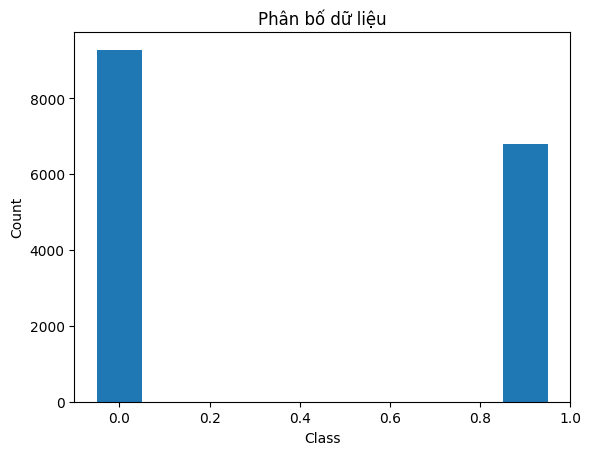

In [ ]:

# Trực quan hóa dữ liệu
def visualize_data(path):
    ds = DataSource()
    train_data = pd.DataFrame(ds.load_data(path))
    plt.hist(train_data.label.to_numpy(), rwidth=1, align='left')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Phân bố dữ liệu")
    plt.savefig('data_distribution.png')
PATH = "/content/train.crash"
visualize_data(PATH)

In [ ]:


# Tiền xử lý văn bản
class Util:
    dict_replace = {
        "ship": "vận chuyển","shop": "cửa hàng","m": "mình","mik":"mình","ko":"không","k":"không","kh":"không","khong":"không","kg":"không","khg":"không","tl":"trả lời",
"rep":"trả lời","r":"rồi","fb":"facebook","face":"faceook","thanks":"cảm ơn","thank":"cảm ơn","tks":"cảm ơn","tk":"cảm ơn","ok":"tốt","oki":"tốt","okie":"tốt","sp":"sản phẩm",
"dc":"được","vs":"với","đt":"điện thoại","thjk":"thích","thik":"thích","qá":"quá","trể":"trễ","bgjo":"bao giờ","h":"giờ","qa":"quá","dep":"đẹp","xau":"xấu","ib":"nhắn tin",
"cute":"dễ thương","sz":"size","good":"tốt","god":"tốt","bt":"bình thường"
    }

    def remove_redundant(self, text):
        return re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    def normalize(self, text):
        text = text.lower()
        words = text.split()
        words = [self.dict_replace.get(w, w) for w in words]
        return " ".join(words)

    def process_text(self, text):
        text = self.remove_redundant(text)
        return self.normalize(text)

In [ ]:

# Mô hình TF-IDF
class DictTfidf:
    def __init__(self, path):
        self.path = path

    def create_vectorizer(self):
        ds = DataSource()
        data = pd.DataFrame(ds.load_data(self.path)).review.tolist()
        util = Util()
        processed_data = [util.process_text(text) for text in data]
        vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
        vectorizer.fit(processed_data)
        return vectorizer


In [ ]:

# Tối ưu tham số
class OptimizeParams:
    def __init__(self, path):
        self.path = path

    def optimize(self):
        x_train_tfidf, y_train, _ = Training(self.path).create_tfidf_vector()
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100], 'kernel': ['linear']}
        clf = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1')
        clf.fit(x_train_tfidf, y_train)
        print(f"Best Parameters: {clf.best_params}, Best Score: {clf.best_score}")
        return clf.best_params_, clf.best_score_


In [ ]:


# Huấn luyện mô hình
class Training:
    def __init__(self, path):
        self.path = path

    def create_tfidf_vector(self):
        vectorizer = DictTfidf(self.path).create_vectorizer()
        ds = DataSource()
        train_data = pd.DataFrame(ds.load_data(self.path))
        x_train = train_data.review.tolist()
        y_train = train_data.label
        x_train_tfidf = vectorizer.transform([Util().process_text(t) for t in x_train])
        return x_train_tfidf, y_train, vectorizer

    def train_model(self):
        x_train_tfidf, y_train, vectorizer = self.create_tfidf_vector()
        model = SVC(C=1, kernel='linear')
        model.fit(x_train_tfidf, y_train)
        joblib.dump(model, '/content/best_model.pkl')
        return model, vectorizer



Best Parameters: {'C': 1, 'kernel': 'linear'}, Best Score: 0.888727938533538
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): đồ đẹp nhưng ship hàng quá lâu
Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ẽit
Bình luận tiêu cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): exit


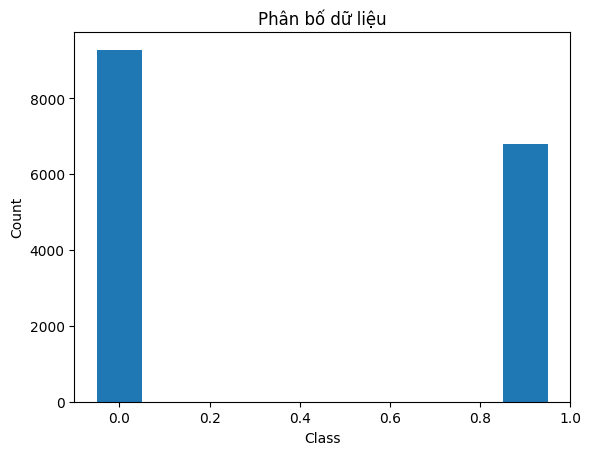

In [ ]:

# Phân loại câu
def classify_sentence(model_path, vectorizer, sentence):
    model = joblib.load(model_path)
    processed_text = Util().process_text(sentence)
    vector_tfidf = vectorizer.transform([processed_text])
    label = model.predict(vector_tfidf)
    return "Bình luận tiêu cực!" if label[0] == 1 else "Bình luận tích cực!"

# Chạy chương trình
if __name__ == '__main__':
    PATH = "/content/train.crash"
    visualize_data(PATH)
    training = Training(PATH)
    model, vectorizer = training.train_model()
    best_params, best_score = OptimizeParams(PATH).optimize()
    print(f"Best Parameters: {best_params}, Best Score: {best_score}")

    while True:
        text = input("Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ").strip()
        if text.lower() == "exit":
            break
        print(classify_sentence('/content/best_model.pkl', vectorizer, text))
